In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", color_codes = True)
np.random.seed(sum(map(ord, "palettes")))

from sklearn.metrics import roc_auc_score

#Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold

/Users/jiajiaping/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/jiajiaping/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# 讀取資料，檢視資料狀況

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [3]:
train.info()
print("-----------")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 no

In [4]:
# 呈現 category 的資料
train.describe(include=["O"])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Allen, Miss. Elisabeth Walton",male,CA. 2343,B96 B98,S
freq,1,577,7,4,644


In [5]:
#呈現類別資料
test.describe(include=["O"])

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Williams, Mr. Richard Norris II",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


# 2.Data Preprocessing 針對對於存活率有關聯的特徵做特徵工程
- filling or drop na-value
- convert the categorical data to numeric data (ordinal value)
- convert to discrete data to numbers of class 
- find the features that are related to survival
- 要同時檢查上述狀況： Training DataSet and Testing DataSet 
- 分散資料 => 分組資料 => 將各組資料再轉成數值資料

In [6]:
#save the id for submitting the final result
test_PassengerId=test["PassengerId"]


# Remove unrelated to survival's feature
train.drop(["PassengerId","Ticket","Cabin"],axis=1,inplace=True)
test.drop(["PassengerId","Ticket","Cabin"],axis=1,inplace=True)

#可以兩個dataframe 用一個list裝起來
train_test_data=[train,test]

# 2.1 Sex map( {"male":1,"female":0} )

In [7]:
for data in train_test_data:
    
    #可以透過 map 將數值直接轉換，就很像是apply
    data["Sex"]=data["Sex"].map({"male":1,"female":0}).astype(int)

In [8]:
train_test_data[0].head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",1,35.0,0,0,8.0500,S


In [9]:
#用平均值去看男性與女性平均存活率多少
train[["Sex","Survived"]].groupby("Sex",as_index=False).mean().sort_values(by="Survived",ascending=True)

#結果得知，女性平均存活率較高，認為這項特徵與存活率有關

,Sex,Survived
1,1,0.188908
0,0,0.742038


# 2.2 P-Class 哪一船艙

In [10]:
train[["Pclass","Survived"]].groupby("Pclass",as_index=False).mean().sort_values(by="Survived",ascending=True)

,Pclass,Survived
2,3,0.242363
1,2,0.472826
0,1,0.629630


# 2.3 Age 填空值

In [11]:
trm=train["Age"].dropna().mean()
trs=train["Age"].dropna().std()
s=np.random.uniform(trm-trs,trm+trs,(200))

In [12]:

# 針對 Age 欄位的空值填上值，有很多種方法，總體平均數等等
age_fill=np.zeros((2,3))

# 取中位數 based on Sex and Pclass 來fillna
for data in train_test_data:
    for se in range(0,2):
        for pc in range(0,3): 
            df=data[(data["Sex"]==se) & (data["Pclass"]==pc+1)]["Age"].dropna() #pc+1 because pclass : 1,2,3
            age_to_fill=df.median()
            age_fill[se,pc]=int(age_to_fill/0.5+0.5)*0.5
    
    for se in range(0,2):
        for pc in range(0,3):
            #loc的 x 座標可以放column 的限制式
            data.loc[(data.Age.isnull()) & (data.Sex==se) & (data.Pclass==pc+1),"Age"]=age_fill[se,pc]
            
    data["Age"]=data["Age"].astype(int)


In [13]:
train.head(5)
test.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,"Kelly, Mr. James",1,34,0,0,7.8292,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",0,47,1,0,7.0000,S
2,2,"Myles, Mr. Thomas Francis",1,62,0,0,9.6875,Q
3,3,"Wirz, Mr. Albert",1,27,0,0,8.6625,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22,1,1,12.2875,S


# bucketization

In [14]:
train["Agebins"]=pd.cut(train["Age"],8)

In [15]:
#越小的越容易存活
train.loc[:,["Agebins","Survived"]].groupby("Agebins").mean().sort_values("Survived",ascending=True)

,Survived
Agebins,
"(60.0, 70.0]",0.222222
"(70.0, 80.0]",0.250000
"(20.0, 30.0]",0.322751
"(10.0, 20.0]",0.379310
"(40.0, 50.0]",0.392857
"(50.0, 60.0]",0.404762
"(30.0, 40.0]",0.448649
"(-0.08, 10.0]",0.593750


In [16]:
def convertAgeToBins(row):
    if row <=10:
        return 0
    elif row >10 and row <=20:
        return 1
    elif row >20 and row <=30:
        return 2
    elif row >30 and row <=40:
        return 3
    elif row >40 and row <=50:
        return 4
    elif row >50 and row <=60:
        return 5
    elif row >60 and row <=70:
        return 6
    elif row >70:
        return 7

In [17]:
#因為Age為離散型態，數值分佈雜亂，我們應該要給他分組，並將每個年齡對應到組別上，而組別的編號是我們自己定義的
for data in train_test_data:
    data["Age"]=data["Age"].apply(convertAgeToBins)
    data["Age"]=data["Age"].astype(int)

# 2.3.1從圖表可以發現，female 存活率比 male 還要高

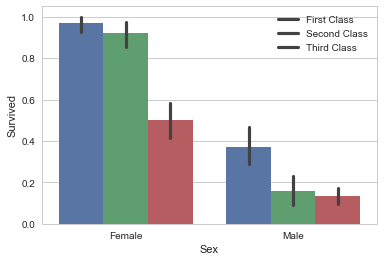

In [18]:
fig = sns.barplot(x="Sex",y="Survived",hue="Pclass",data=train)
fig.set_xticklabels(["Female", "Male"])
fig.legend(["First Class","Second Class","Third Class"],loc="upper right")

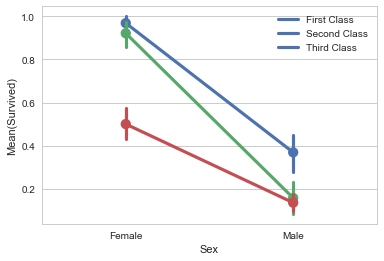

In [19]:
fig=sns.pointplot(x="Sex",y="Survived",hue="Pclass",data=train)

fig.set_xlabel("Sex")
fig.set_xticklabels(["Female","Male"])
fig.set_ylabel("Mean(Survived)")
fig.legend(["First Class","Second Class","Third Class"],loc="upper right")

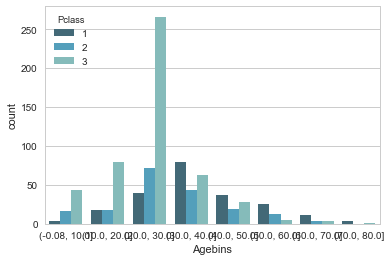

In [20]:
sns.countplot(x="Agebins",hue="Pclass",data=train,palette="GnBu_d")

# 2.3.2 完成 age 的 填值 與 transform 
### drop Agebins

In [21]:
train=train.drop(["Agebins"],axis=1)
train_test_data=[train,test]


In [22]:
train.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",1,2,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,3,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",0,2,0,0,7.9250,S


# Family Size ( 總數可能才會有意義 )

In [23]:
# 總數才有意義
for data in train_test_data:
    # column 可以直接相加
    data["FamilySize"]=data["Parch"]+data["SibSp"]

In [24]:
train[["FamilySize","Survived"]].groupby(["FamilySize"],as_index=False).mean().sort_values(by="Survived",ascending=False)

,FamilySize,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.303538
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


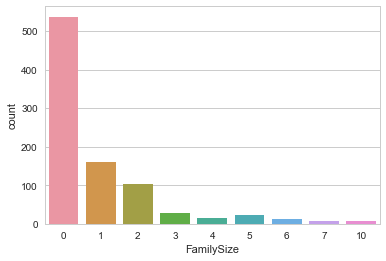

In [25]:
sns.countplot(x="FamilySize",data=train)

In [26]:
train=train.drop(["Parch","SibSp"],axis=1)
test=test.drop(["Parch","SibSp"],axis=1)
train_test_data=[train,test]

In [27]:
train

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamilySize
0,0,3,"Braund, Mr. Owen Harris",1,2,7.2500,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,3,71.2833,C,1
2,1,3,"Heikkinen, Miss. Laina",0,2,7.9250,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,3,53.1000,S,1
4,0,3,"Allen, Mr. William Henry",1,3,8.0500,S,0
5,0,3,"Moran, Mr. James",1,2,8.4583,Q,0
6,0,1,"McCarthy, Mr. Timothy J",1,5,51.8625,S,0
7,0,3,"Palsson, Master. Gosta Leonard",1,0,21.0750,S,4
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,2,11.1333,S,2
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,1,30.0708,C,1


# 2.5 Embarked
- 2 na value => subsititute na for mode

In [28]:
#dropna()會回傳扣掉空值的內容(dataframe)
Embarked_freq=train.Embarked.dropna().mode()[0] #從series取得值
for data in train_test_data:
    data["Embarked"] = data["Embarked"].fillna(Embarked_freq)
train,test= train_test_data[0],train_test_data[1]

In [29]:
train[["Embarked","Survived"]].groupby("Embarked",as_index=False).mean().sort_values("Survived",ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [30]:
for data in train_test_data:
    data["Embarked"]=data["Embarked"].map({"S":0,"C":1,"Q":2}).astype(int)

In [31]:
train.head(3)

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamilySize
0,0,3,"Braund, Mr. Owen Harris",1,2,7.2500,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,3,71.2833,1,1
2,1,3,"Heikkinen, Miss. Laina",0,2,7.9250,0,0


# 2.6 Fare
- testint dataset 有一個空值

In [32]:
Fare_freq=test.Fare.dropna().mode()[0] # 取得Series內的值
for data in train_test_data:
    data["Fare"]=data["Fare"].fillna(Fare_freq)

In [33]:
#先用 training dataset 看規則
train['FareBins'] = pd.qcut(train['Fare'], 5)
train[['FareBins', 'Survived']].groupby(['FareBins'], 
                                        as_index = False).mean().sort_values(by = 'Survived', ascending = True)

,FareBins,Survived
1,"(7.854, 10.5]",0.201087
0,"(-0.001, 7.854]",0.217877
2,"(10.5, 21.679]",0.424419
3,"(21.679, 39.688]",0.444444
4,"(39.688, 512.329]",0.642045


In [34]:
def convertFareToBins(row):
    if row<=7.854:
        return 0
    elif row >7.854 and row <=10.5:
        return 1
    elif row >10.5 and row <=21.679:
        return 2
    elif row >21.679 and row <=39.688:
        return 3
    elif row >39.688 and row <=5512.329:
        return 4

In [35]:
#然後根據規則在適用於 training data and testing data
for data in train_test_data:
    data["Fare"]=data["Fare"].apply(convertFareToBins)
    data["Fare"]=data["Fare"].astype(int)

In [36]:
train,test = train_test_data[0],train_test_data[1]
train = train.drop(["FareBins"],axis=1)

In [37]:
train

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamilySize
0,0,3,"Braund, Mr. Owen Harris",1,2,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,3,4,1,1
2,1,3,"Heikkinen, Miss. Laina",0,2,1,0,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,3,4,0,1
4,0,3,"Allen, Mr. William Henry",1,3,1,0,0
5,0,3,"Moran, Mr. James",1,2,1,2,0
6,0,1,"McCarthy, Mr. Timothy J",1,5,4,0,0
7,0,3,"Palsson, Master. Gosta Leonard",1,0,2,0,4
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,2,2,0,2
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,1,3,1,1


# 2.7 Title

In [38]:
train.head(3)

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamilySize
0,0,3,"Braund, Mr. Owen Harris",1,2,0,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,3,4,1,1
2,1,3,"Heikkinen, Miss. Laina",0,2,1,0,0


In [39]:
train["Title"]=train["Name"].str.split(",").str.get(1).str.split(".").str.get(0).str.strip()
test["Title"]=test["Name"].str.split(",").str.get(1).str.split(".").str.get(0).str.strip()

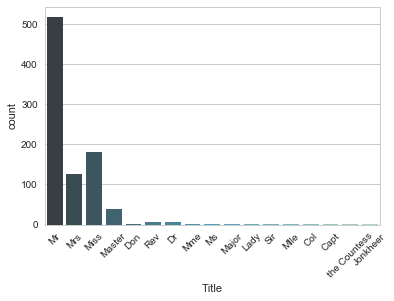

In [40]:
fig=sns.countplot(x="Title",data=train,palette="GnBu_d")
fig=plt.setp(fig.get_xticklabels(),rotation=45)

In [41]:
train_test_data=[train,test]
for data in train_test_data:
    data["Title"]

In [42]:
train["Title"].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Ms                1
Jonkheer          1
Lady              1
Don               1
the Countess      1
Capt              1
Sir               1
Mme               1
Name: Title, dtype: int64

In [43]:
test["Title"].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dona        1
Ms          1
Dr          1
Name: Title, dtype: int64

In [44]:
#有些值太少了，把少的歸類成一類
train_test_data=[train,test]
for dest in train_test_data:
    #replace找不到值的的話不會出錯
    dest["Title"]=dest["Title"].replace(["Dr","Rev","Col","Major","Don","the Countess","Sir","Capt","Jonkheer","Dona"],"Lamped")
    dest["Title"]=dest["Title"].replace(["Lady","Mlle","Ms","Mme"],"Miss")

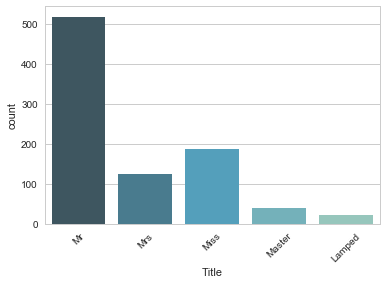

In [45]:
fig2=sns.countplot(x="Title",data=train,palette="GnBu_d")
fig2=plt.setp(fig2.get_xticklabels(),rotation=45)

In [46]:
train[["Title","Survived"]].groupby(["Title"],as_index=False).mean().sort_values(by="Survived",ascending=False)

,Title,Survived
4,Mrs,0.792000
2,Miss,0.705882
1,Master,0.575000
0,Lamped,0.318182
3,Mr,0.156673


In [47]:
# 在把類別資料轉換成numeric
# 以類別來看可以直接用map轉換 (nominal)
# 以數值來看，會需要用到apply (ordinal)
for data in train_test_data:
    # map 可以之後再轉換型別
    data["Title"]=data["Title"].map({"Mr":1,"Miss":2,"Mrs":3,"Master":4,"Lamped":5}).astype(int)

In [48]:
train.head(3)

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,FamilySize,Title
0,0,3,"Braund, Mr. Owen Harris",1,2,0,0,1,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,3,4,1,1,3
2,1,3,"Heikkinen, Miss. Laina",0,2,1,0,0,2


In [49]:
# Name 不需要了
train.drop("Name",axis=1,inplace=True)
test.drop("Name",axis=1,inplace=True)

In [50]:
test.head(3)

,Pclass,Sex,Age,Fare,Embarked,FamilySize,Title
0,3,1,3,0,2,0,1
1,3,0,4,0,0,1,3
2,2,1,6,1,2,0,1


# Machine Learning Algorithm
- 選用三種ML演算法 KNN，Decision Tree，SVM 

In [51]:
result=pd.read_csv("gender_submission.csv")
r=np.array(result["Survived"]) # 取得 testing dataset 的 label
y_train=train["Survived"] # 把label去掉
X_train=train.drop("Survived",axis=1)
X_test=test

X_train.shape,y_train.shape,X_test.shape

((891, 7), (891,), (418, 7))

# SVM

In [52]:
svc = SVC(random_state = 0)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
SVC_score = svc.score(X_train, y_train)
print("SVC Accuracy  score = %.2f" % (SVC_score*100))

SVC Accuracy  score = 84.18


# KNN

In [53]:
KNN=KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train,y_train)
y_pred_knn=KNN.predict(X_test)
KNN_score=KNN.score(X_train,y_train)
print("KNN Accuracy score = {:.2f}".format(KNN_score*100))

KNN Accuracy score = 85.41


In [54]:
y_pred_trainknn=KNN.predict(X_train)
print(y_pred_knn)

[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0
 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0
 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 1]


In [55]:
# prediction against testing data set
ss=pd.DataFrame({"Predicted":y_pred_knn,"Result":r})
len(ss[ss["Predicted"]==ss["Result"]])/len(ss)

0.8660287081339713

In [56]:
# prediction against training data set
ss=pd.DataFrame({"Predicted":y_pred_trainknn,"Result":y_train})
len(ss[ss["Predicted"]==ss["Result"]])/len(ss)

0.8540965207631874

# Decision Tree

In [57]:
DT = DecisionTreeClassifier(max_depth = 6, 
                            max_features = 'auto', 
                            min_samples_leaf = 2,
                            random_state = 125)
DT.fit(X_train, y_train)
y_pred_dt = DT.predict(X_test)
print(y_pred_dt)
DT_score = DT.score(X_train, y_train)
print("Decision Tree accuracy score = {:.2f}".format(DT_score*100))

[0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 0 1 1 0 0 1 0 0 1]
Decision Tree accuracy score = 84.29


In [58]:
y_pred_traindt=DT.predict(X_train)
print(y_pred_knn)

[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 0 0
 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 1
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 1 0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 0 0 0 0
 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 1]


In [59]:
# prediction against "testing" data set
ss=pd.DataFrame({"Predicted":y_pred_dt,"Result":r})
len(ss[ss["Predicted"]==ss["Result"]])/len(ss)

0.8588516746411483

In [60]:
# prediction against "training" data set
ss=pd.DataFrame({"Predicted":y_pred_traindt,"Result":y_train})
len(ss[ss["Predicted"]==ss["Result"]])/len(ss)

0.8428731762065096

In [61]:
Predictive_models = pd.DataFrame({
    'Model': ['SVM', 'KNN', 'DT'],
    'Score': [SVC_score, KNN_score, DT_score]})
Predictive_models.sort_values(by ='Score', ascending=True)

,Model,Score
0,SVM,0.841751
2,DT,0.842873
1,KNN,0.854097


# Cross Validation
- 提升 model 精準度
- 針對 Decision Tree
- 針對 K-NearestNeighbor

# Decision Tree CrossValidation

In [62]:
# 還沒調參數前
DT = DecisionTreeClassifier()
y_train = train.loc[:,"Survived"]
X_train = train.drop(["Survived"], axis = 1)


kfold = KFold(n=len(train), n_folds = 5, shuffle = True, random_state = 0)
kfold_score = cross_val_score(DT, X_train, y_train, cv = kfold)

kfold_score_mean = np.mean(kfold_score)
  
print("Decision Tree accuracy score per fold : ", kfold_score, "\n")
print("Average accuracy score : {:.4f}".format(kfold_score_mean))

Decision Tree accuracy score per fold :  [ 0.81005587  0.7247191   0.81460674  0.80898876  0.75280899] 

Average accuracy score : 0.7822


In [63]:
# Tune 參數
DT = DecisionTreeClassifier()
y_train = train.loc[:,"Survived"]
X_train = train.drop(["Survived"], axis = 1)

parameters = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
             'max_features' : ["auto", None, "sqrt", "log2"],
             'random_state': [0, 25, 75, 125, 250],
             'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
clf = GridSearchCV(DT, parameters)
clf.fit(X_train, y_train)

DT_Model = clf.best_estimator_
print (clf.best_score_, clf.best_params_)
print(DT_Model)

0.8316498316498316 {'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 2, 'random_state': 125}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=125,
            splitter='best')


In [64]:
#調整完參數
DT = DecisionTreeClassifier(max_depth = 6, 
                            max_features = 'auto', 
                            min_samples_leaf = 2,
                            random_state = 125)
X_train = train.drop(["Survived"], axis = 1)
y_train = train.loc[:,"Survived"]

kfold = KFold(n=len(train), n_folds = 5, shuffle = True, random_state = 125)
DT.fit(X_train, y_train)
kfold_score = cross_val_score(DT, X_train, y_train, cv = kfold)
kfold_score_mean = np.mean(kfold_score)

y_pred_dt = DT.predict(X_test)

y_pred_traindt=DT.predict(X_train)

# prediction against "testing" data set
ss=pd.DataFrame({"Predicted":y_pred_dt,"Result":r})
print(len(ss[ss["Predicted"]==ss["Result"]])/len(ss))

# prediction against "Training" data set
ss=pd.DataFrame({"Predicted":y_pred_traindt,"Result":y_train})
print(len(ss[ss["Predicted"]==ss["Result"]])/len(ss))
  
print("Decision Tree accuracy score per fold : ", kfold_score, "\n")
print("Average accuracy score : {:.4f}".format(kfold_score_mean)) 

0.8588516746411483
0.8428731762065096
Decision Tree accuracy score per fold :  [ 0.81564246  0.84269663  0.85955056  0.79775281  0.79213483] 

Average accuracy score : 0.8216


In [65]:
#調整完參數
DT = DecisionTreeClassifier()
X_train = train.drop(["Survived"], axis = 1)
y_train = train.loc[:,"Survived"]

kfold = KFold(n=len(train), n_folds = 5, shuffle = True, random_state = 125)
DT.fit(X_train, y_train)
kfold_score = cross_val_score(DT, X_train, y_train, cv = kfold)
kfold_score_mean = np.mean(kfold_score)

y_pred_dt = DT.predict(X_test)

y_pred_traindt=DT.predict(X_train)

# prediction against "testing" data set
ss=pd.DataFrame({"Predicted":y_pred_dt,"Result":r})
print(len(ss[ss["Predicted"]==ss["Result"]])/len(ss))

# prediction against "Training" data set
ss=pd.DataFrame({"Predicted":y_pred_traindt,"Result":y_train})
print(len(ss[ss["Predicted"]==ss["Result"]])/len(ss))
  
print("Decision Tree accuracy score per fold : ", kfold_score, "\n")
print("Average accuracy score : {:.4f}".format(kfold_score_mean)) 

0.8444976076555024
0.8945005611672279
Decision Tree accuracy score per fold :  [ 0.78212291  0.80337079  0.76404494  0.79213483  0.78089888] 

Average accuracy score : 0.7845


In [66]:
Titanic_submission = pd.DataFrame({
        "PassengerId": test_PassengerId,
        "Survived": y_pred_dt
    })
Titanic_submission.to_csv("result_dt.csv",index=False)

# KNN Cross Validation

In [67]:
# 還沒調參數前
KNN = KNeighborsClassifier()
y_train = train.loc[:,"Survived"]
X_train = train.drop(["Survived"], axis = 1)


kfold = KFold(n=len(train), n_folds = 5, shuffle = True, random_state = 0)
kfold_score = cross_val_score(DT, X_train, y_train, cv = kfold)

kfold_score_mean = np.mean(kfold_score)
  
print("Decision Tree accuracy score per fold : ", kfold_score, "\n")
print("Average accuracy score : {:.4f}".format(kfold_score_mean))

Decision Tree accuracy score per fold :  [ 0.81005587  0.7247191   0.8258427   0.80337079  0.74719101] 

Average accuracy score : 0.7822


In [68]:
# Tune 參數
KNN = KNeighborsClassifier()
y_train = train.loc[:,"Survived"]
X_train = train.drop(["Survived"], axis = 1)

# 去調參數
parameters = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
             'weights':["uniform","distance"],
              'algorithm':["auto", "ball_tree", "kd_tree", "brute"],
             'leaf_size': [1, 30, 75, 125],
             'p': [1,2]}

clf = GridSearchCV(KNN, parameters)
clf.fit(X_train, y_train)

KNN_Model = clf.best_estimator_
print (clf.best_score_, clf.best_params_)
print(KNN_Model) 

0.8338945005611672 {'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=1,
           weights='uniform')


In [69]:
# 調參數後
KNN = KNeighborsClassifier(n_neighbors=10,weights="uniform",algorithm="ball_tree",leaf_size=1,p=1)
X_train = train.drop(["Survived"], axis = 1)
y_train = train.loc[:,"Survived"]

kfold = KFold(n=len(train), n_folds = 5, shuffle = True, random_state = 125)
KNN.fit(X_train, y_train)

# prediction against "Training" data set validation dataset
kfold_score = cross_val_score(KNN, X_train, y_train, cv = kfold)
kfold_score_mean = np.mean(kfold_score)

y_pred_knn = KNN.predict(X_test)

y_pred_trainknn=KNN.predict(X_train)

# prediction against "testing" data set
ss=pd.DataFrame({"Predicted":y_pred_knn,"Result":r})
print(len(ss[ss["Predicted"]==ss["Result"]])/len(ss))

# prediction against "Training" data set
ss=pd.DataFrame({"Predicted":y_pred_trainknn,"Result":y_train})
print(len(ss[ss["Predicted"]==ss["Result"]])/len(ss))
  
print("Decision Tree accuracy score per fold : ", kfold_score, "\n")
print("Average accuracy score : {:.4f}".format(kfold_score_mean)) 

0.8779904306220095
0.8518518518518519
Decision Tree accuracy score per fold :  [ 0.7877095   0.84269663  0.81460674  0.81460674  0.79775281] 

Average accuracy score : 0.8115


In [70]:
Titanic_submission = pd.DataFrame({
        "PassengerId": test_PassengerId,
        "Survived": y_pred_knn
    })
Titanic_submission.to_csv("result_knn.csv",index=False)
print("Done")

Done
